# Weight visualization

In [ ]:
import torch
from torchvision import models
model = models.resnet34(pretrained=True)
_ = model.eval()
device = 'cuda' if torch.cuda.is_available else 'cpu'
model.to(device)
print(device)

cuda


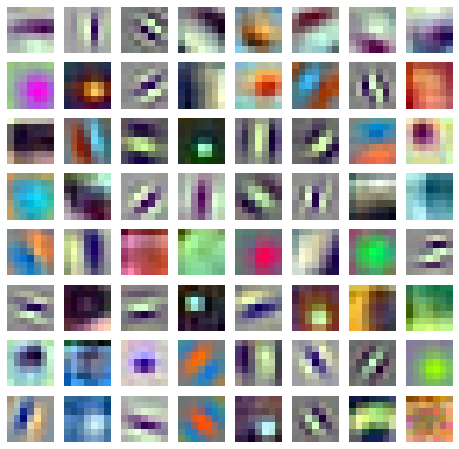

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
  weights = model.conv1.weight[i].permute(1, 2, 0).detach().clone().cpu().numpy()
  weights = (weights - weights.min()) / (weights.max() - weights.min())
  ax.imshow(weights)
  ax.set_axis_off()
plt.show()


# Feature visualization

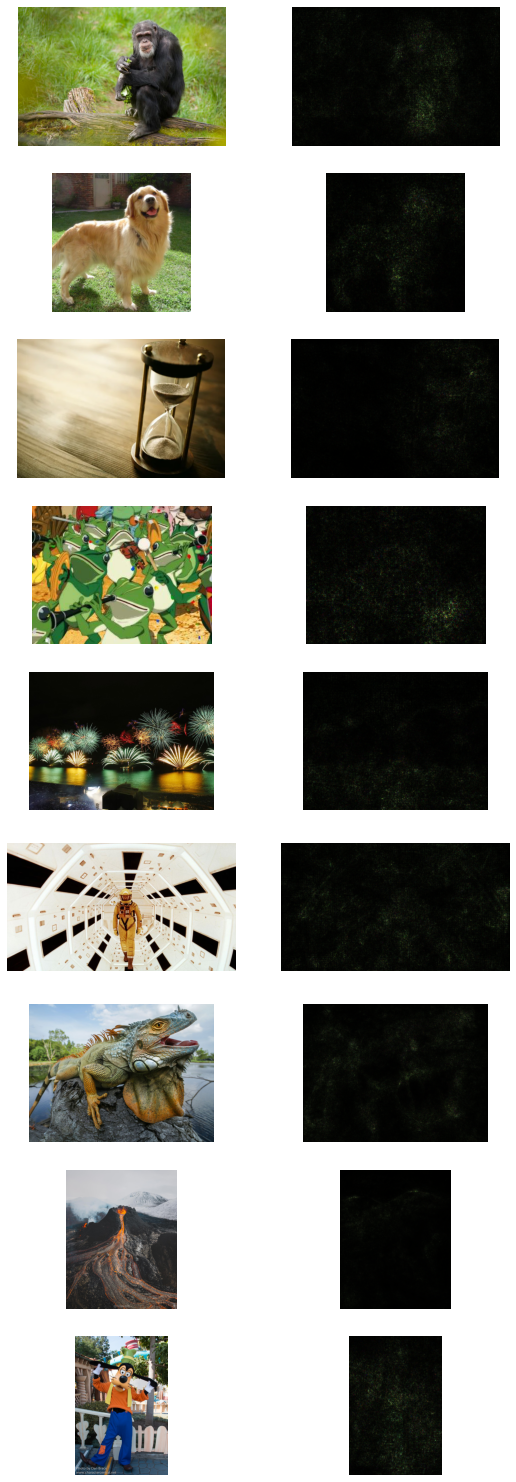

In [ ]:
from PIL import Image
import requests
from io import BytesIO

import numpy as np
from torchvision import transforms

def load_image(url):
  response = requests.get(url)
  return Image.open(BytesIO(response.content))

urls = [
  "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg",
  "https://anipassion.com/ow_userfiles/plugins/animal/breed_image_56efffab3e169.jpg",
  # "https://upload.wikimedia.org/wikipedia/commons/f/f2/Platypus.jpg",
  "https://static5.depositphotos.com/1017950/406/i/600/depositphotos_4061551-stock-photo-hourglass.jpg",
  "https://img.nealis.fr/ptv/img/p/g/1465/1464424.jpg",
  "http://www.tudobembresil.com/wp-content/uploads/2015/11/nouvelancopacabana.jpg",
  "https://ychef.files.bbci.co.uk/976x549/p0639ffn.jpg",
  "https://www.thoughtco.com/thmb/Dk3bE4x1qKqrF6LBf2qzZM__LXE=/1333x1000/smart/filters:no_upscale()/iguana2-b554e81fc1834989a715b69d1eb18695.jpg",
  "https://i.redd.it/mbc00vg3kdr61.jpg",
  "https://static.wikia.nocookie.net/disneyfanon/images/a/af/Goofy_pulling_his_ears.jpg",
]

def deprocess_image(z):
    # Normalize array: center on 0.
    z -= z.mean()
    z /= z.std() + 1e-5
    z = (255 * np.clip(z+0.5, 0, 1)).astype("uint8")
    return z

def normalize_01(x):
  EPS = 1e-5
  return (x - x.min() + EPS) / (x.max() - x.min() + EPS)

# urls = urls[:2]

fig, axes = plt.subplots(len(urls), 2, figsize=(9, 3 * len(urls)))

_ = [ax.set_axis_off() for ax in axes.flatten()]

for i, url in enumerate(urls):
  img = load_image(url)
  inputs = transforms.ToTensor()(img).unsqueeze_(0)
  inputs.requires_grad_()
  logits = model(inputs.to(device))
  top_class = logits.argmax(-1)[0]
  logits[0, top_class].backward()

  grad = inputs.grad
  out = grad.clone().abs()[0].permute(1, 2, 0)
  out = normalize_01(out)
  axes[i, 0].imshow(inputs[0].permute(1, 2, 0).detach().numpy())
  axes[i, 1].imshow(out, cmap='hot')
plt.show()

In [ ]:
!nvidia-smi

Sun Dec  5 06:48:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    41W / 250W |   8853MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

(568, 850, 3)
torch.Size([568, 850, 3])
(400, 400, 3)
torch.Size([400, 400, 3])
(400, 600, 3)
torch.Size([400, 600, 3])


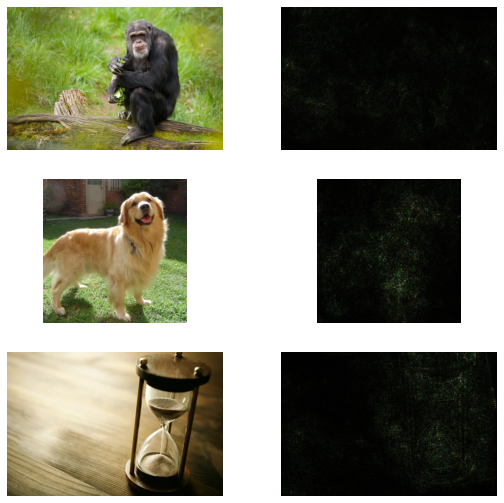

In [ ]:
urls = urls[:3]

fig, axes = plt.subplots(len(urls), 2, figsize=(9, 3 * len(urls)))

_ = [ax.set_axis_off() for ax in axes.flatten()]

random_transform = transforms.Compose([
  # transforms.RandAugment(),
  transforms.RandomRotation(degrees=15),
  transforms.ColorJitter(
      brightness=2.0,
      contrast=0.5,
      saturation=1.0,
      hue=0.5,
  ),
])

batch_size = 32

for i, url in enumerate(urls):
  img = load_image(url)

  x = transforms.ToTensor()(img)
  inputs = torch.empty(batch_size, *x.shape)
  for j in range(batch_size):
    inputs[j] = random_transform(x)

  inputs.requires_grad_()
  logits = model(inputs.to(device))
  top_class = logits.argmax(-1)[0]
  logits[0, top_class].backward()

  grad = inputs.grad.mean(0)
  out = grad.clone().abs().permute(1, 2, 0)
  out = normalize_01(out)
  x_np = x.permute(1, 2, 0).detach().numpy()
  print(x_np.shape)
  print(out.shape)
  axes[i, 0].imshow(x_np)
  axes[i, 1].imshow(out, cmap='Reds')

# plt.show()

In [ ]:
import torch
from torchvision import models
resnet34 = models.resnet34(pretrained=True)
resnet34.eval()

layer = resnet34.layer3
# layer = resnet34.conv1
layer = resnet34.layer3[-1]
layer = resnet34

vals = {}
def hook(model, inputs, outputs):
  # print(inputs[0].shape)
  # print(outputs.shape)
  vals['activations'] = outputs

layer.register_forward_hook(hook)
layer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
x = torch.randn((1, 3, 64, 64))
_ = resnet34(x)

False

torch.Size([1, 3, 255, 255])
True


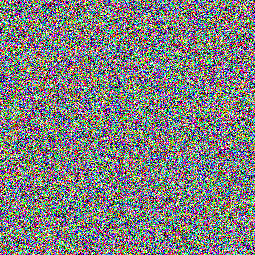

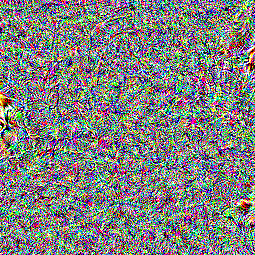

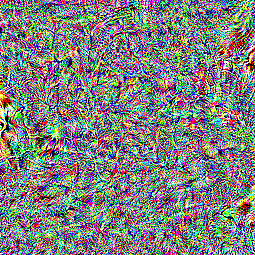

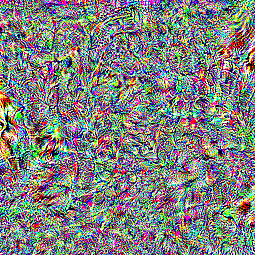

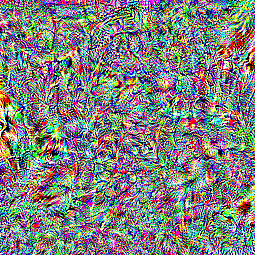

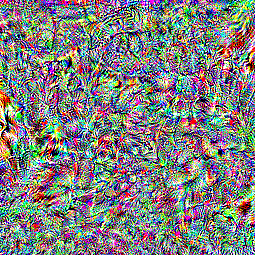

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def deprocess_image(z):
    # Normalize array: center on 0., ensure variance is 0.15
    z -= z.mean()
    z /= z.std() + 1e-5
    z *= 0.5
    z = 255 * np.clip(z+0.5, 0, 1)
    return z.astype("uint8")

x = torch.randn((1, 3, 255, 255), requires_grad=True)
x = torch.nn.Parameter((torch.rand((1, 3, 255, 255)) - 0.5))
print(x.shape)
print(x.requires_grad)

def display_tensor(t):
  img = deprocess_image(t[0].permute(1, 2, 0).clone().detach().numpy())
  display(Image.fromarray(img))
  print('')

lr = 1e1
n_iter = 200
for i in range(n_iter):
  if i % (n_iter // 5) == 0:
    display_tensor(x)

  _ = resnet34(x)
  actv = vals['activations']
  out = actv[0, 207].mean()
  out.backward()
  grad = x.grad / torch.norm(x.grad)
  x.data += lr * grad
  x.grad.zero_()

display_tensor(x)

torch.Size([1, 3, 64, 64])
torch.float32


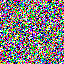

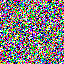

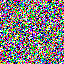

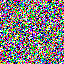

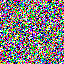

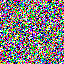

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch import fft

def deprocess_image(z):
    # Normalize array: center on 0.
    z -= z.mean()
    z /= z.std() + 1e-5
    z = (255 * np.clip(z+0.5, 0, 1)).astype("uint8")
    return z

# x = torch.randn((1, 3, 255, 255), requires_grad=True)
h, w = 64, 64
p0  = (torch.rand((1, 3, h, w)) - 0.5) * 0.25
x_f = torch.nn.Parameter(p0)
print(x_f.shape)
print(x_f.dtype)
x = fft.irfft2(x_f, s=(h, w))

def display_tensor(t):
  img = deprocess_image(t[0].permute(1, 2, 0).clone().detach().numpy())
  display(Image.fromarray(img))
  print('')

lr = 1e3
n_iter = 100
for i in range(n_iter):
  if i % (n_iter // 5) == 0:
    display_tensor(x)

  _ = resnet34(x)
  actv = vals['activations']
  out = actv[0, 0].mean()
  out.backward()
  # grad = x_f.grad / torch.norm(x_f.grad)
  x_f.data += lr * grad
  x_f.grad.zero_()

display_tensor(x)

torch.Size([1, 3, 224, 224])
torch.float32


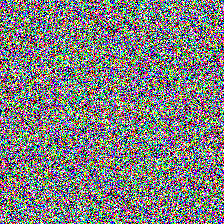

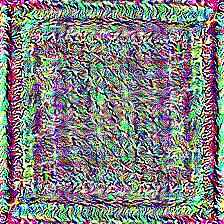

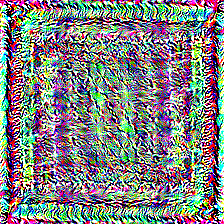

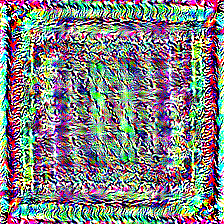

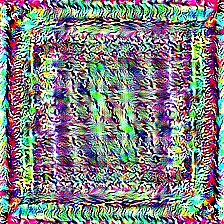

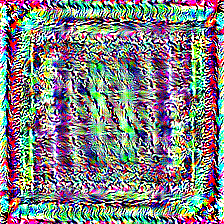

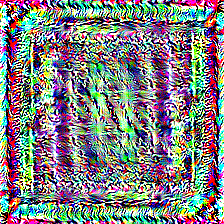

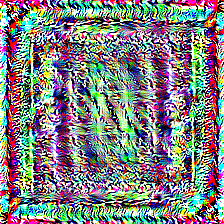

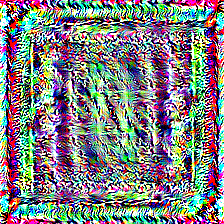

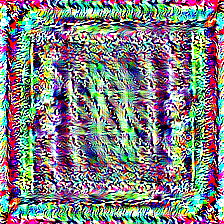

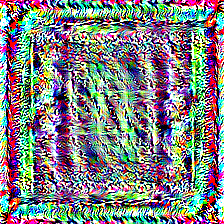

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch import fft


# From https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/spatial.py
def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""
    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)


def fft_image(shape, sd=None, decay_power=1):
    batch, channels, h, w = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = (batch, channels) + freqs.shape + (2,) # 2 for imaginary and real components
    sd = sd or 0.01

    spectrum_real_imag_t = (torch.randn(*init_val_size) * sd).to(device).requires_grad_(True)

    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale = torch.tensor(scale).float()[None, None, ..., None].to(device)

    def inner():
        scaled_spectrum_t = scale * spectrum_real_imag_t
        if TORCH_VERSION >= "1.7.0":
            import torch.fft
            if type(scaled_spectrum_t) is not torch.complex64:
                scaled_spectrum_t = torch.view_as_complex(scaled_spectrum_t)
            image = torch.fft.irfftn(scaled_spectrum_t, s=(h, w), norm='ortho')
        else:
            import torch
            image = torch.irfft(scaled_spectrum_t, 2, normalized=True, signal_sizes=(h, w))
        image = image[:batch, :channels, :h, :w]
        magic = 4.0 # Magic constant from Lucid library; increasing this seems to reduce saturation
        image = image / magic
        return image
    return [spectrum_real_imag_t], inner


def deprocess_image(z):
    # Normalize array: center on 0.
    z -= z.mean()
    z /= z.std() + 1e-5
    z = (255 * np.clip(z+0.5, 0, 1)).astype("uint8")
    return z

# x = torch.randn((1, 3, 255, 255), requires_grad=True)
# h, w = 64, 64
h, w = 224, 224
p0  = (torch.rand((1, 3, h, w)) - 0.5) * 0.25
x_f = torch.nn.Parameter(p0)
print(x_f.shape)
print(x_f.dtype)

# kshape = (1, 3, h, w)
# params, x = fft_image(shape)

def display_tensor(t):
  img = deprocess_image(t[0].permute(1, 2, 0).clone().detach().numpy())
  display(Image.fromarray(img))
  print('')

# params = x_f.parameters()
lr = 1e1
# opt = optim.Adam(params, lr)

n_iter = 50
n_show = 10
for i in range(n_iter):
  x = fft.irfft2(x_f, s=(h, w))
  if i % (n_iter // n_show) == 0:
    display_tensor(x)

  _ = resnet34(x)
  actv = vals['activations']
  out = actv[0, 207].mean()
  out.backward()
  grad = x_f.grad / torch.norm(x_f.grad)
  x_f.data += lr * grad
  x_f.grad.zero_()

x = fft.irfft2(x_f, s=(h, w))
display_tensor(x)

torch.Size([1, 3, 224, 224])
torch.float32


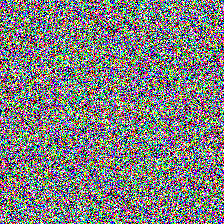

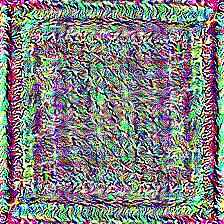

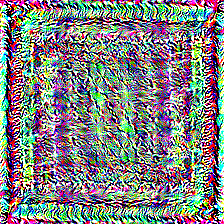

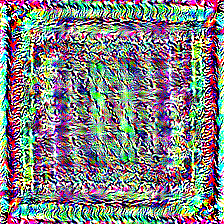

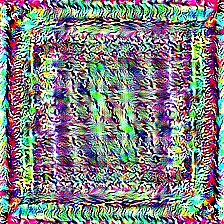

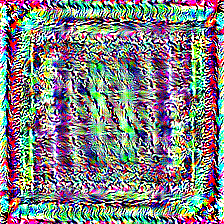

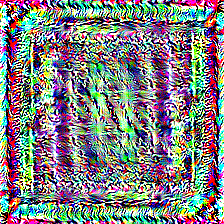

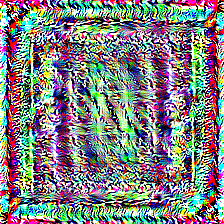

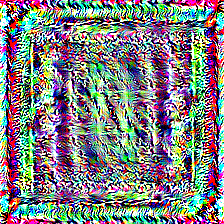

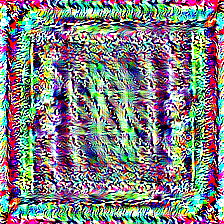

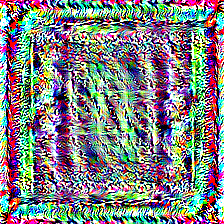

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch import fft


# From https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/spatial.py
def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""
    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)


def fft_image(shape, sd=None, decay_power=1):
    batch, channels, h, w = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = (batch, channels) + freqs.shape + (2,) # 2 for imaginary and real components
    sd = sd or 0.01

    spectrum_real_imag_t = (torch.randn(*init_val_size) * sd).to(device).requires_grad_(True)

    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale = torch.tensor(scale).float()[None, None, ..., None].to(device)

    def inner():
        scaled_spectrum_t = scale * spectrum_real_imag_t
        if TORCH_VERSION >= "1.7.0":
            import torch.fft
            if type(scaled_spectrum_t) is not torch.complex64:
                scaled_spectrum_t = torch.view_as_complex(scaled_spectrum_t)
            image = torch.fft.irfftn(scaled_spectrum_t, s=(h, w), norm='ortho')
        else:
            import torch
            image = torch.irfft(scaled_spectrum_t, 2, normalized=True, signal_sizes=(h, w))
        image = image[:batch, :channels, :h, :w]
        magic = 4.0 # Magic constant from Lucid library; increasing this seems to reduce saturation
        image = image / magic
        return image
    return [spectrum_real_imag_t], inner


def deprocess_image(z):
    # Normalize array: center on 0.
    z -= z.mean()
    z /= z.std() + 1e-5
    z = (255 * np.clip(z+0.5, 0, 1)).astype("uint8")
    return z

# x = torch.randn((1, 3, 255, 255), requires_grad=True)
# h, w = 64, 64
h, w = 224, 224
p0  = (torch.rand((1, 3, h, w)) - 0.5) * 0.25
param, image_f  = fft_image((1, 3, h, w))
param = param[0]

# kshape = (1, 3, h, w)
# params, x = fft_image(shape)

def display_tensor(t):
  img = deprocess_image(t[0].permute(1, 2, 0).clone().detach().numpy())
  display(Image.fromarray(img))
  print('')

# params = x_f.parameters()
lr = 1e1
opt = optim.Adam(params, lr)

n_iter = 50
n_show = 10
for i in range(n_iter):
  x = fft.irfft2(x_f, s=(h, w))
  if i % (n_iter // n_show) == 0:
    display_tensor(x)

  _ = resnet34(x)
  actv = vals['activations']
  out = actv[0, 207].mean()
  out.backward()
  
  grad = x_f.grad / torch.norm(x_f.grad)
  x_f.data += lr * grad
  x_f.grad.zero_()

x = fft.irfft2(x_f, s=(h, w))
display_tensor(x)

.

.

.

.

.

.

.

.

.

.

